In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from scipy.io import loadmat
from pyod.utils.utility import standardizer
from pyod.models.combination import average, maximization

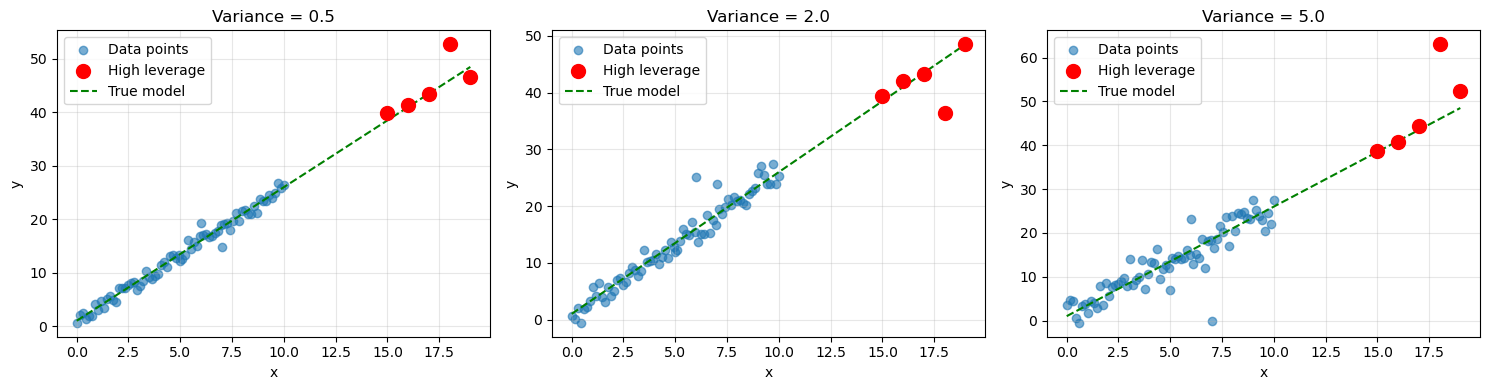

In [14]:
## Lab 2 - Olariu Razvan-Gabriel 411 DS

## Exercise 1: Leverage Scores - 1D Linear Model

def compute_leverage_1d(X, y):
    n = len(X)
    X = np.column_stack([X, np.ones(n)])
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    leverage = np.diag(H)
    return leverage

a = 2.5
b = 1.0
n_samples = 100

variance_vals = [0.5, 2.0, 5.0]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, sigma2 in enumerate(variance_vals):
    x_regular = np.linspace(0, 10, 70)
    y_regular = a * x_regular + b + np.random.normal(0, np.sqrt(sigma2), len(x_regular))
    
    x_high_var_x = np.array([15, 16, 17])
    y_high_var_x = a * x_high_var_x + b + np.random.normal(0, np.sqrt(sigma2), len(x_high_var_x))
    
    x_high_var_y = np.array([5, 6, 7])
    y_high_var_y = a * x_high_var_y + b + np.random.normal(0, 5*np.sqrt(sigma2), len(x_high_var_y))
    
    x_high_both = np.array([18, 19])
    y_high_both = a * x_high_both + b + np.random.normal(0, 6*np.sqrt(sigma2), len(x_high_both))
    
    X_all = np.concatenate([x_regular, x_high_var_x, x_high_var_y, x_high_both])
    y_all = np.concatenate([y_regular, y_high_var_x, y_high_var_y, y_high_both])
    
    leverages = compute_leverage_1d(X_all, y_all)
    
    top_indices = np.argsort(leverages)[-5:]
    
    axes[idx].scatter(X_all, y_all, alpha=0.6, label='Data points')
    axes[idx].scatter(X_all[top_indices], y_all[top_indices], color='red', s=100, 
                     label='High leverage', zorder=5)
    
    x_line = np.linspace(X_all.min(), X_all.max(), 100)
    y_line = a * x_line + b
    axes[idx].plot(x_line, y_line, 'g--', label='True model')
    
    axes[idx].set_title(f'Variance = {sigma2}')
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('y')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

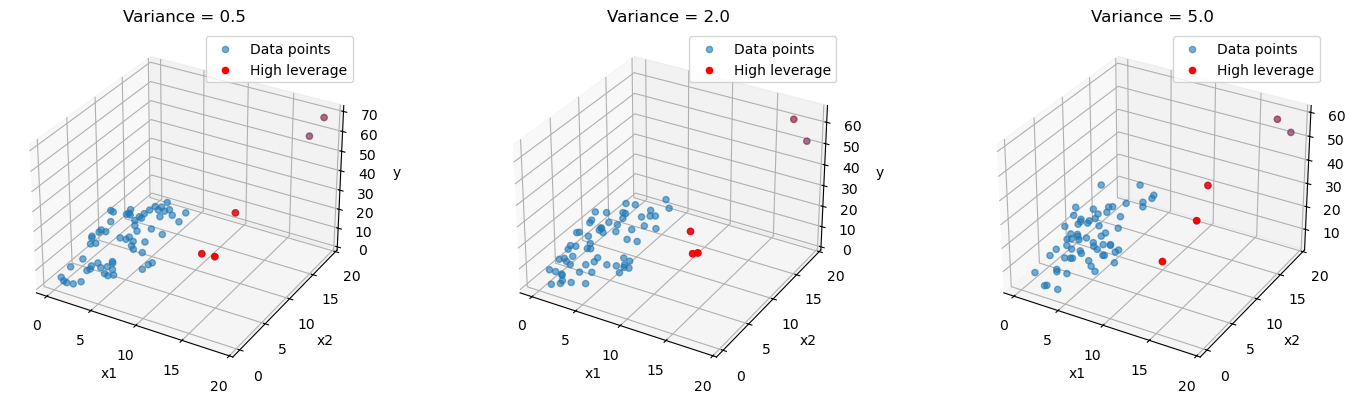

In [15]:
# Exercise 1: Leverage Scores - 2D Linear Model

def compute_leverage_2d(X1, X2, y):
    n = len(X1)
    X_design = np.column_stack([X1, X2, np.ones(n)])
    H = X_design @ np.linalg.inv(X_design.T @ X_design) @ X_design.T
    leverage = np.diag(H)
    return leverage

a = 2.0
b = 1.5
c = 0.5

variance_vals = [0.5, 2.0, 5.0]
fig = plt.figure(figsize=(15, 4))

for idx, sigma2 in enumerate(variance_vals):
    x1_regular = np.random.uniform(0, 10, 60)
    x2_regular = np.random.uniform(0, 10, 60)
    y_regular = a * x1_regular + b * x2_regular + c + np.random.normal(0, np.sqrt(sigma2), len(x1_regular))
    
    x1_high_x = np.array([15, 16, 17])
    x2_high_x = np.random.uniform(0, 10, 3)
    y_high_x = a * x1_high_x + b * x2_high_x + c + np.random.normal(0, np.sqrt(sigma2), len(x1_high_x))
    
    x1_high_y = np.random.uniform(5, 7, 3)
    x2_high_y = np.random.uniform(5, 7, 3)
    y_high_y = a * x1_high_y + b * x2_high_y + c + np.random.normal(0, 5*np.sqrt(sigma2), len(x1_high_y))
    
    x1_high_both = np.array([18, 19])
    x2_high_both = np.array([18, 19])
    y_high_both = a * x1_high_both + b * x2_high_both + c + np.random.normal(0, 6*np.sqrt(sigma2), len(x1_high_both))
    
    X1_all = np.concatenate([x1_regular, x1_high_x, x1_high_y, x1_high_both])
    X2_all = np.concatenate([x2_regular, x2_high_x, x2_high_y, x2_high_both])
    y_all = np.concatenate([y_regular, y_high_x, y_high_y, y_high_both])
    
    leverages = compute_leverage_2d(X1_all, X2_all, y_all)
    
    top_indices = np.argsort(leverages)[-5:]
    
    ax = fig.add_subplot(1, 3, idx+1, projection='3d')
    ax.scatter(X1_all, X2_all, y_all, alpha=0.6, label='Data points')
    ax.scatter(X1_all[top_indices], X2_all[top_indices], y_all[top_indices], 
               color='red', label='High leverage')
    
    ax.set_title(f'Variance = {sigma2}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    ax.legend()

plt.tight_layout()
plt.show()

n_neighbors=3: Train BA=0.9606, Test BA=1.0000
n_neighbors=5: Train BA=0.9878, Test BA=1.0000
n_neighbors=10: Train BA=0.9878, Test BA=1.0000
n_neighbors=20: Train BA=0.9878, Test BA=1.0000


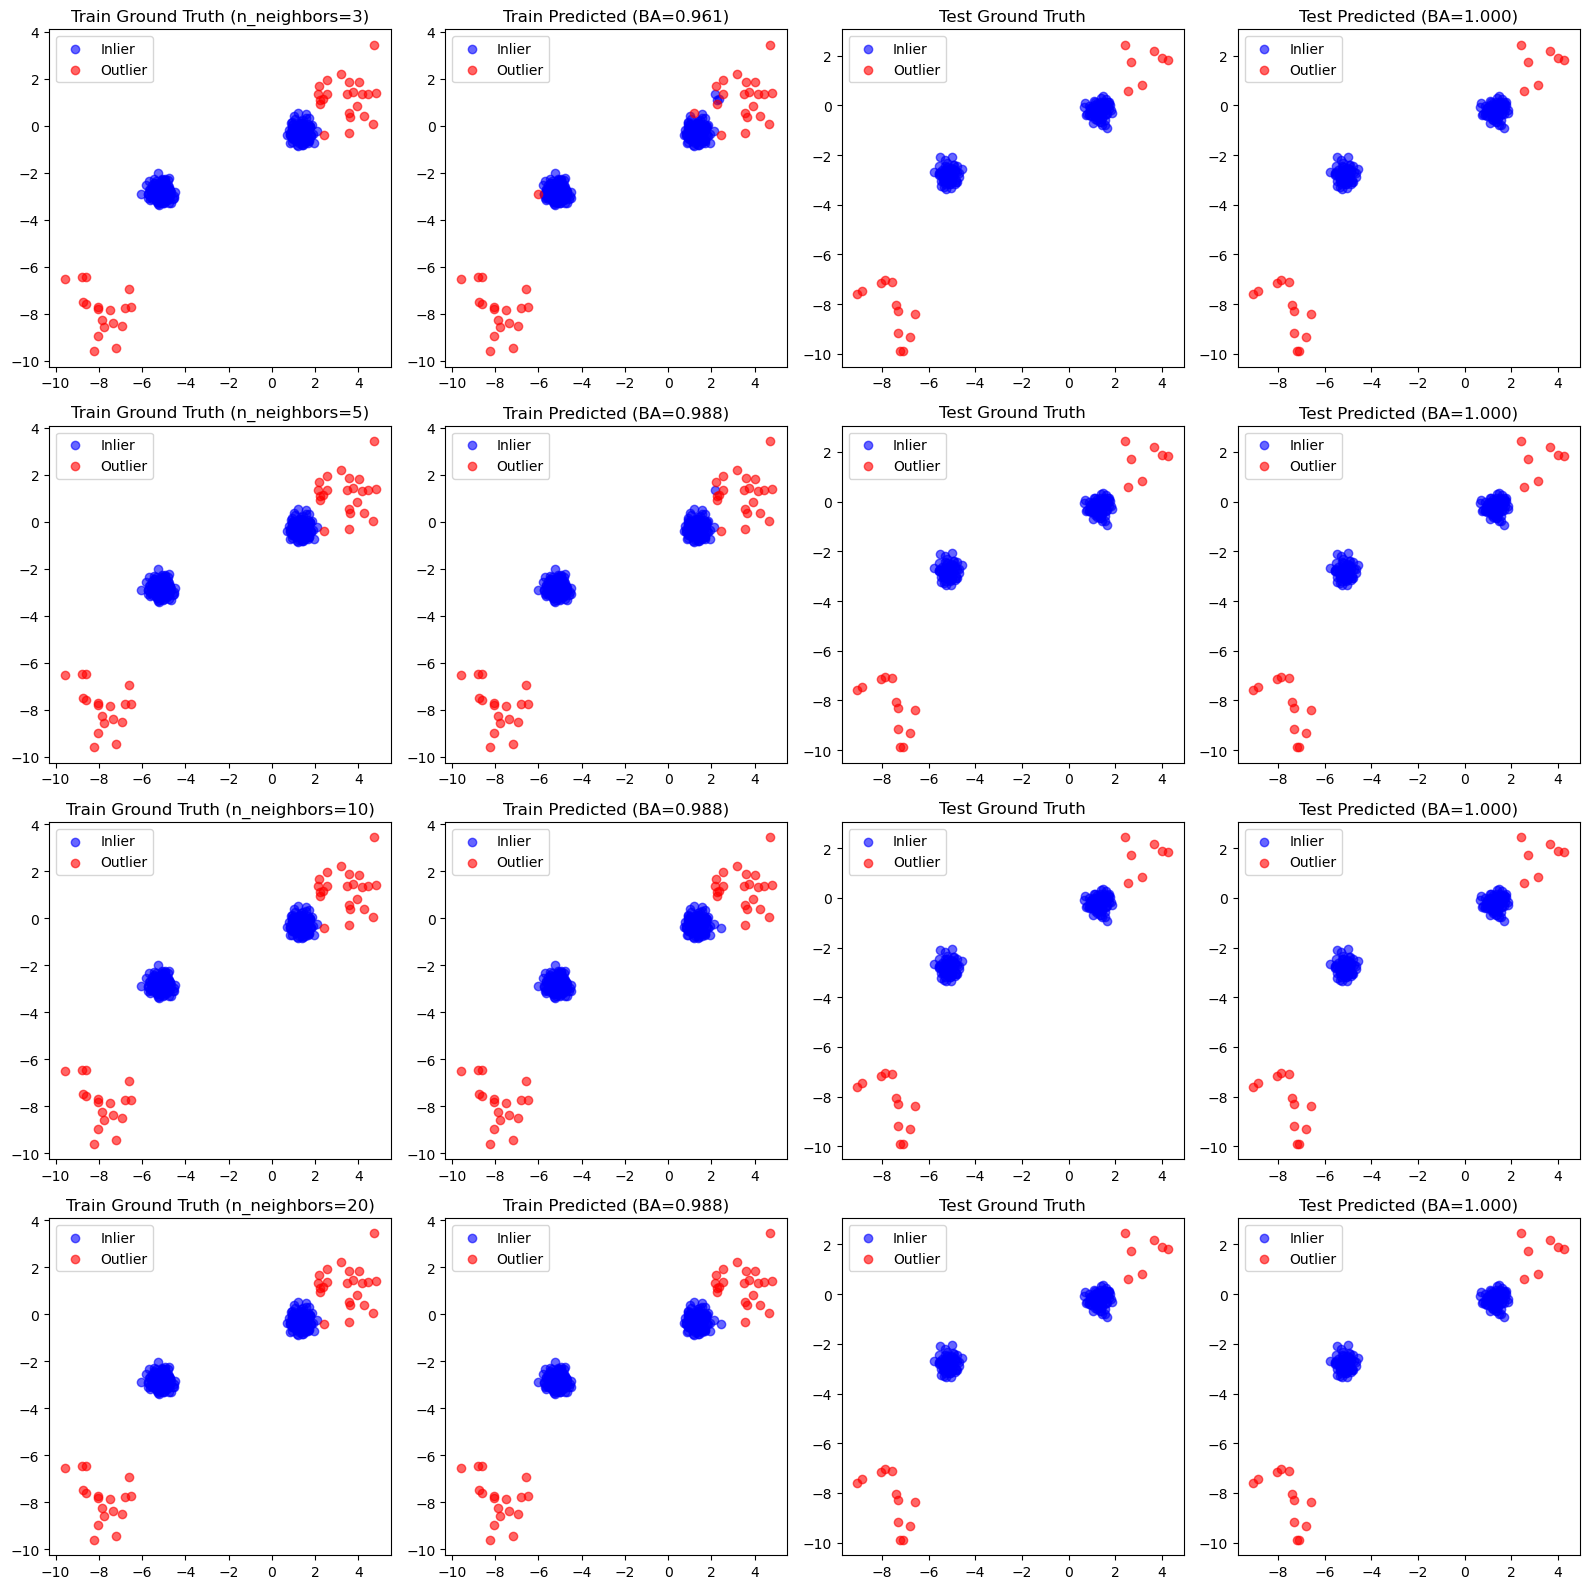

In [16]:
# Exercise 2: KNN on Synthetic Clusters

X_train, X_test, y_train, y_test = generate_data_clusters(
    n_train=400,
    n_test=200,
    n_clusters=2,
    n_features=2,
    contamination=0.1,
    size='same',
    density='same',
    dist=0.25,
    random_state=42
)

n_neighbors_vals = [3, 5, 10, 20]

fig, axes = plt.subplots(len(n_neighbors_vals), 4, figsize=(16, 4*len(n_neighbors_vals)))

for i, n_neighbors in enumerate(n_neighbors_vals):
    knn = KNN(n_neighbors=n_neighbors, contamination=0.1)
    knn.fit(X_train)
    
    y_train_pred = knn.labels_
    y_test_pred = knn.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, y_train_pred)
    test_ba = balanced_accuracy_score(y_test, y_test_pred)
    
    axes[i, 0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
                       c='blue', label='Inlier', alpha=0.6)
    axes[i, 0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
                       c='red', label='Outlier', alpha=0.6)
    axes[i, 0].set_title(f'Train Ground Truth (n_neighbors={n_neighbors})')
    axes[i, 0].legend()
    
    axes[i, 1].scatter(X_train[y_train_pred == 0, 0], X_train[y_train_pred == 0, 1], 
                       c='blue', label='Inlier', alpha=0.6)
    axes[i, 1].scatter(X_train[y_train_pred == 1, 0], X_train[y_train_pred == 1, 1], 
                       c='red', label='Outlier', alpha=0.6)
    axes[i, 1].set_title(f'Train Predicted (BA={train_ba:.3f})')
    axes[i, 1].legend()
    
    axes[i, 2].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], 
                       c='blue', label='Inlier', alpha=0.6)
    axes[i, 2].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], 
                       c='red', label='Outlier', alpha=0.6)
    axes[i, 2].set_title(f'Test Ground Truth')
    axes[i, 2].legend()
    
    axes[i, 3].scatter(X_test[y_test_pred == 0, 0], X_test[y_test_pred == 0, 1], 
                       c='blue', label='Inlier', alpha=0.6)
    axes[i, 3].scatter(X_test[y_test_pred == 1, 0], X_test[y_test_pred == 1, 1], 
                       c='red', label='Outlier', alpha=0.6)
    axes[i, 3].set_title(f'Test Predicted (BA={test_ba:.3f})')
    axes[i, 3].legend()
    
    print(f'n_neighbors={n_neighbors}: Train BA={train_ba:.4f}, Test BA={test_ba:.4f}')

plt.tight_layout()
plt.show()

n_neighbors=5: KNN found 21 outliers, LOF found 21 outliers
n_neighbors=10: KNN found 21 outliers, LOF found 21 outliers
n_neighbors=20: KNN found 21 outliers, LOF found 21 outliers


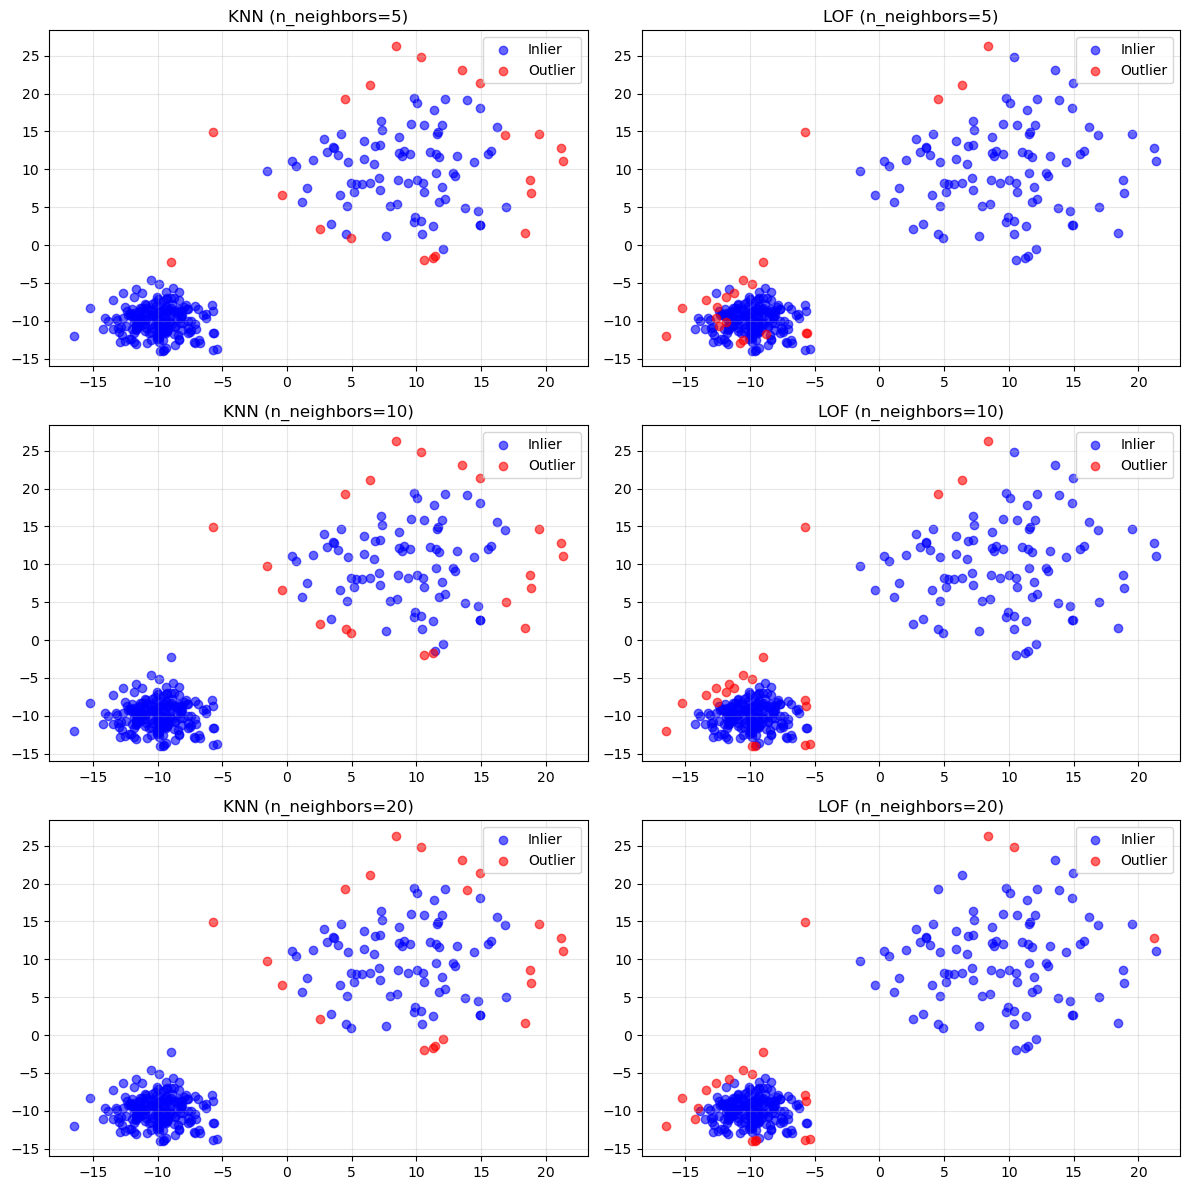

In [17]:
# Exercise 3: KNN vs LOF on Different Density Clusters

X1, y1 = make_blobs(n_samples=200, n_features=2, centers=[(-10, -10)], 
                     cluster_std=2.0, random_state=42)
X2, y2 = make_blobs(n_samples=100, n_features=2, centers=[(10, 10)], 
                     cluster_std=6.0, random_state=42)

X_data = np.vstack([X1, X2])

n_neighbors_vals = [5, 10, 20]

fig, axes = plt.subplots(len(n_neighbors_vals), 2, figsize=(12, 4*len(n_neighbors_vals)))

for i, n_neighbors in enumerate(n_neighbors_vals):
    knn = KNN(n_neighbors=n_neighbors, contamination=0.07)
    knn.fit(X_data)
    y_pred_knn = knn.labels_
    
    lof = LOF(n_neighbors=n_neighbors, contamination=0.07)
    lof.fit(X_data)
    y_pred_lof = lof.labels_
    
    axes[i, 0].scatter(X_data[y_pred_knn == 0, 0], X_data[y_pred_knn == 0, 1], 
                       c='blue', label='Inlier', alpha=0.6)
    axes[i, 0].scatter(X_data[y_pred_knn == 1, 0], X_data[y_pred_knn == 1, 1], 
                       c='red', label='Outlier', alpha=0.6)
    axes[i, 0].set_title(f'KNN (n_neighbors={n_neighbors})')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].scatter(X_data[y_pred_lof == 0, 0], X_data[y_pred_lof == 0, 1], 
                       c='blue', label='Inlier', alpha=0.6)
    axes[i, 1].scatter(X_data[y_pred_lof == 1, 0], X_data[y_pred_lof == 1, 1], 
                       c='red', label='Outlier', alpha=0.6)
    axes[i, 1].set_title(f'LOF (n_neighbors={n_neighbors})')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)
    
    print(f'n_neighbors={n_neighbors}: KNN found {np.sum(y_pred_knn)} outliers, LOF found {np.sum(y_pred_lof)} outliers')

plt.tight_layout()
plt.show()

In [18]:
# Exercise 4: Ensemble Methods on Cardio Dataset

data = loadmat('cardio.mat')
X = data['X']
y = data['y'].flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test = standardizer(X_train, X_test)

contamination_rate = np.sum(y_train) / len(y_train)
print(f'Contamination rate: {contamination_rate:.4f}')

train_scores = []
test_scores = []

n_neighbors_range = range(30, 121, 10)

for n_neighbors in n_neighbors_range:
    knn = KNN(n_neighbors=n_neighbors, contamination=contamination_rate)
    knn.fit(X_train)
    
    y_train_pred = knn.labels_
    y_test_pred = knn.predict(X_test)
    
    train_ba = balanced_accuracy_score(y_train, y_train_pred)
    test_ba = balanced_accuracy_score(y_test, y_test_pred)
    
    print(f'KNN n_neighbors={n_neighbors}: Train BA={train_ba:.4f}, Test BA={test_ba:.4f}')
    
    train_scores.append(knn.decision_scores_)
    test_scores.append(knn.decision_function(X_test))

train_scores = np.array(train_scores).T
test_scores = np.array(test_scores).T

train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

avg_train_scores = average(train_scores_norm)
avg_test_scores = average(test_scores_norm)

threshold_avg = np.quantile(avg_train_scores, 1 - contamination_rate)
y_train_pred_avg = (avg_train_scores > threshold_avg).astype(int)
y_test_pred_avg = (avg_test_scores > threshold_avg).astype(int)

train_ba_avg = balanced_accuracy_score(y_train, y_train_pred_avg)
test_ba_avg = balanced_accuracy_score(y_test, y_test_pred_avg)

print(f'\nAverage Strategy: Train BA={train_ba_avg:.4f}, Test BA={test_ba_avg:.4f}')

max_train_scores = maximization(train_scores_norm)
max_test_scores = maximization(test_scores_norm)

threshold_max = np.quantile(max_train_scores, 1 - contamination_rate)
y_train_pred_max = (max_train_scores > threshold_max).astype(int)
y_test_pred_max = (max_test_scores > threshold_max).astype(int)

train_ba_max = balanced_accuracy_score(y_train, y_train_pred_max)
test_ba_max = balanced_accuracy_score(y_test, y_test_pred_max)

print(f'Maximization Strategy: Train BA={train_ba_max:.4f}, Test BA={test_ba_max:.4f}')

Contamination rate: 0.0906
KNN n_neighbors=30: Train BA=0.6919, Test BA=0.7546
KNN n_neighbors=40: Train BA=0.7061, Test BA=0.7473
KNN n_neighbors=50: Train BA=0.7156, Test BA=0.7483
KNN n_neighbors=60: Train BA=0.7156, Test BA=0.7879
KNN n_neighbors=70: Train BA=0.7204, Test BA=0.7963
KNN n_neighbors=80: Train BA=0.7298, Test BA=0.7952
KNN n_neighbors=90: Train BA=0.7346, Test BA=0.7869
KNN n_neighbors=100: Train BA=0.7441, Test BA=0.7963
KNN n_neighbors=110: Train BA=0.7488, Test BA=0.8046
KNN n_neighbors=120: Train BA=0.7583, Test BA=0.8129

Average Strategy: Train BA=0.7204, Test BA=0.7879
Maximization Strategy: Train BA=0.7346, Test BA=0.7816
